In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy, random, os,colorsys

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import poisson, chisquare
from scipy.stats import mode

import os, joblib
from joblib import Parallel, delayed

In [2]:
def random_unit_vector(n):
    vec = np.random.randn(n)  # Draw from standard normal
    vec /= np.linalg.norm(vec)  # Normalize to unit length
    return vec

class sim_cell:  
    new_lineage_label = 1
    def __init__(self, parent_state, differentiation_vec, lineage_label):
        self.alive = True
        self.differentiation_vec = differentiation_vec
        self.lineage_label = lineage_label

        parent_state = parent_state.copy()
        for i in range(len(parent_state)):
            parent_state[i] += np.random.normal(0, sim_cell.measure_error_var)
        self.state_vec = parent_state
        
    def proliferate(self):
        if self.differentiation_vec is not None and np.random.binomial(1, sim_cell.mutation_prob) == 1:
            sim_cell.new_lineage_label += 1
            step = np.array([np.random.normal(axis_scalar * sim_cell.ss_mean, sim_cell.ss_var) for axis_scalar in self.differentiation_vec]) \
                                                                                        + random_unit_vector(len(self.differentiation_vec))*5
            return sim_cell(self.state_vec + step, self.differentiation_vec, sim_cell.new_lineage_label)
        else:
            return sim_cell(self.state_vec, self.differentiation_vec,  self.lineage_label)
    
    def cell_cycle(self):
        if self.alive:
            self.alive = np.random.binomial(1, sim_cell.death_rate) == 0
            if self.differentiation_vec is None:
                if np.random.binomial(1, sim_cell.commit_diff_prob) == 1:
                    self.differentiation_vec = sim_cell.differentiation_directions[np.random.choice(range(len(sim_cell.differentiation_directions)))]
            if np.random.binomial(1, sim_cell.birth_rate) == 1:
                return self.proliferate()
            else:
                return None
        

In [3]:
def simulate_scRNA(args):
    n_dims = args['n_dims']
    sim_cell.birth_rate = args['birth_rate']
    sim_cell.death_rate = args['death_rate']
    sim_cell.mutation_prob = args['mutation_prob']
    sim_cell.ss_mean = args['ss_mean']
    sim_cell.ss_var = args['ss_var']
    sim_cell.measure_error_var = args['measure_error_var']
    sim_cell.differentiation_directions = [random_unit_vector(n_dims) for _ in range(args['n_diff_directions'])]
    sim_cell.commit_diff_prob = args['commit_diff_prob']
    immigration_rate=args['immigration_rate']
    max_population=args['max_population']
    max_steps=args['max_steps']

    step_counter = 0
    population = [sim_cell(np.zeros(n_dims), None, 1)]
    while len(population) < max_population:
        step_counter += 1
        if step_counter > max_steps:
            return population
        if len(population) == 0:
            population = [sim_cell(np.zeros(n_dims), None, 1)]
        new_cells = [sim_cell(np.zeros(n_dims), None, 1) for _ in range(int(immigration_rate))]
        
        dead_cell_index = []
        for i in range(len(population)):
            new_cell = population[i].cell_cycle()
            if new_cell is not None:
                new_cells.append(new_cell)
            if not population[i].alive:
                dead_cell_index.append(i)
        for i in reversed(dead_cell_index):
            population.pop(i)
        population += new_cells
    return list(np.random.choice(population, size = max_population, replace = False))

In [8]:
# s<0, r>0, γ=0, high p
args1 = {
    "n_dims": 100,
    "n_diff_directions": 1,
    "birth_rate": 0.2,
    "death_rate": 0.10,
    "mutation_prob": 0.8,
    "commit_diff_prob": 1,
    "immigration_rate": 0, 
    "ss_mean": 40,
    "ss_var": 5,
    "measure_error_var": 0.4,
    "max_population":20000, 
    "max_steps":300,
}
# s<0, r<0, γ>0, low p
args2 = {
    "n_dims": 100,
    "n_diff_directions": 1,
    "birth_rate": 0.2,
    "death_rate": 0.22,
    "mutation_prob": 0.8,
    "commit_diff_prob": 1,
    "immigration_rate": 700, 
    "ss_mean": 40,
    "ss_var": 5,
    "measure_error_var": 0.4,
    "max_population":20000, 
    "max_steps":300,
}
# s>0, r>0, γ=0, low p
args3 = {
    "n_dims": 100,
    "n_diff_directions": 1,
    "birth_rate": 0.32,
    "death_rate": 0.10,
    "mutation_prob": 0.2,
    "commit_diff_prob": 1,
    "immigration_rate": 0, 
    "ss_mean": 40,
    "ss_var": 5,
    "measure_error_var": 0.4,
    "max_population":20000, 
    "max_steps":300,
}
population1 = simulate_scRNA(args1)
population2 = simulate_scRNA(args2)
population3 = simulate_scRNA(args3)
# population4 = simulate_scRNA(args4)


In [9]:
label_color_map = {
    "s<0, r>0, γ=0, high p": "blue",
    "s<0, r>0, γ=0, low p": "purple",
    "s<0, r<0, γ>0, high p": "orange",
    "s<0, r<0, γ>0, low p": "green",
    "s>0, r>0, γ=0, high p": "red",
    "s>0, r>0, γ=0, low p": "brown",
}
labels = ["s<0, r>0, γ=0, high p", "s<0, r<0, γ>0, high p", "s>0, r>0, γ=0, low p"]
state_vecs = np.array([cell.state_vec for cell in population1 + population2 + population3])
pca = PCA(n_components=3)
pca_result = pca.fit_transform(state_vecs)

pca_pop1 = pca_result[:len(population1)]
pca_pop2 = pca_result[len(population1):len(population1) + len(population2)]
pca_pop3 = pca_result[len(population1) + len(population2):len(population1) + len(population2) + len(population3)]
# pca_pop4 = pca_result[len(population1) + len(population2) + len(population3):]

In [10]:
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import minimum_spanning_tree
import networkx as nx
from scipy.stats import entropy

def extract_mst_features(data):
    dist_matrix = squareform(pdist(data))
    mst_sparse = minimum_spanning_tree(dist_matrix)
    mst_graph = nx.from_scipy_sparse_array(mst_sparse)

    num_nodes = len(mst_graph.nodes)
    # --- Edge lengths ---
    edge_lengths = np.array([d['weight'] for u, v, d in mst_graph.edges(data=True)])
    avg_edge_length = edge_lengths.mean()
    edge_length_std = edge_lengths.std()
    edge_length_cv = edge_length_std / avg_edge_length

    # --- Spectral features ---
    laplacian = nx.laplacian_matrix(mst_graph).todense()
    lap_eigvals = np.linalg.eigvalsh(laplacian)
    spectral_radius = lap_eigvals.max()
    algebraic_connectivity_norm = lap_eigvals[1] / lap_eigvals[-1]
    laplacian_energy = np.sum((lap_eigvals - lap_eigvals.mean())**2)

    # --- Branching structure features ---
    degrees = dict(mst_graph.degree())
    internal_nodes = [n for n, d in degrees.items() if d >= 2]
    internal_degrees = [degrees[n] / num_nodes for n in internal_nodes]
    branching_factor_mean = np.mean(internal_degrees) if internal_degrees else 0
    branching_factor_std = np.std(internal_degrees) if internal_degrees else 0
    proportion_leaf_nodes = np.sum(degrees == 1) / num_nodes
    leaf_nodes = [n for n, d in mst_graph.degree() if d == 1]
    branching_index = (num_nodes - len(leaf_nodes)) / len(leaf_nodes)
    degrees = np.array([deg for _, deg in mst_graph.degree()])
    unique_degrees, counts = np.unique(degrees, return_counts=True)
    degree_probs = counts / counts.sum()
    degree_entropy = entropy(degree_probs)

    mst_features = {
        'edge_length_cv': edge_length_cv,
        'algebraic_connectivity_norm': algebraic_connectivity_norm,
        'laplacian_energy_norm': laplacian_energy / num_nodes,
        'branching_factor_mean': branching_factor_mean , 
        'branching_factor_std': branching_factor_std,
        "proportion_leaf_nodes": proportion_leaf_nodes,
        "degree_entropy": degree_entropy,
        "branching_index": branching_index,
    }
    return mst_features



def FPC_radius_based(X):
    nbrs = NearestNeighbors(n_neighbors=100).fit(X)
    distances, _ = nbrs.kneighbors(X)
    density = -distances[:, 1:].mean(axis=1)
    centers = [np.argmax(density)]
    distances = pairwise_distances(X, X[centers[-1]].reshape(1, -1)).flatten()
    dists = pairwise_distances(X)
    min_dist_threshold = np.percentile(dists, 25)
    while True:
        next_center = np.argmax(distances)
        max_dist = distances[next_center]
        if max_dist < min_dist_threshold:
            break
        centers.append(next_center)
        new_distances = pairwise_distances(X, X[next_center].reshape(1, -1)).flatten()
        distances = np.minimum(distances, new_distances)
    center_points = X[centers]
    labels = np.argmin(pairwise_distances(X, center_points), axis=1)
    print("Number of clusters:", len(centers))
    return centers, labels

def extract_population_feature_dict(local_state_vecs): 
    def linear_regression_test(x, y):
        slope, intercept = np.polyfit(x, y, 1)
        y_pred = slope * x + intercept
        residuals = y - y_pred
        se_res = np.sqrt(np.sum(residuals**2) / (len(x) - 2))
        Sxx = np.sum((x - np.mean(x)) ** 2)
        slope_se = se_res / np.sqrt(Sxx)
        t_stat = slope / slope_se
        return [slope, slope_se, t_stat]
    
    local_state_vecs = StandardScaler().fit_transform(local_state_vecs)
    PCs = PCA(n_components=20).fit_transform(local_state_vecs)
    feature_dict = {}
    feature_dict = extract_mst_features(PCs)

    cluster_centers, cluster_labels = FPC_radius_based(PCs)
    sorted_abundance = np.array(sorted(np.unique(cluster_labels, return_counts=True)[1], reverse=True))
    ranks = np.arange(1, len(sorted_abundance) + 1)
    log_abundance = np.log(sorted_abundance)
    log_ranks = np.log(ranks)

    # Fit power law
    slope, slope_se, t_stat = linear_regression_test(log_ranks, log_abundance)
    feature_dict['FPC_loglog_slope'] = slope
    # Fit exponential
    slope, slope_se, t_stat = linear_regression_test(ranks, log_abundance)
    feature_dict['FPC_logy_slope'] = slope

    # n1 / n2
    feature_dict['FPC_n1n2'] = sorted_abundance[0] / sorted_abundance[1]
    feature_dict['FPC_n_clusters'] = len(sorted_abundance)
    return feature_dict

In [11]:
# %%capture
rf_model = joblib.load('./data/rf_model.pkl')

chosen_indices = []
pred_labels = []
confidence_scores = []
n_clusters = []
for _ in range(200):
    chosen_indices.append(np.random.choice(range(len(state_vecs))))
    random_point = state_vecs[chosen_indices[-1]]
    # knn
    knn = NearestNeighbors(n_neighbors = 1000, algorithm='auto')
    knn.fit(state_vecs)
    distances, indices = knn.kneighbors([random_point])
    # cluster
    local_state_vecs = np.array([state_vecs[index] for index in indices[0]])
    feature_dict = extract_population_feature_dict(local_state_vecs)
    input_vec = np.array([feature_dict[k] for k in sorted(feature_dict.keys())])
    pred_labels.append(rf_model.predict([input_vec])[0])
    all_tree_probs = np.array([tree.predict_proba([input_vec]) for tree in rf_model.estimators_])
    tree_preds = np.array([np.argmax(probs) for probs in all_tree_probs])  # shape: [n_trees]
    consensus_label, count = mode(tree_preds, keepdims=False)
    percentage_votes = np.sum(tree_preds == consensus_label) / len(rf_model.estimators_)
    confidence_scores.append(percentage_votes)
    n_clusters.append(0)


Number of clusters: 21
Number of clusters: 53
Number of clusters: 25
Number of clusters: 48
Number of clusters: 22
Number of clusters: 104
Number of clusters: 200
Number of clusters: 116
Number of clusters: 26
Number of clusters: 21
Number of clusters: 68
Number of clusters: 21
Number of clusters: 25
Number of clusters: 20
Number of clusters: 24
Number of clusters: 94
Number of clusters: 85
Number of clusters: 29
Number of clusters: 84
Number of clusters: 93
Number of clusters: 20
Number of clusters: 68
Number of clusters: 28
Number of clusters: 118
Number of clusters: 68
Number of clusters: 28
Number of clusters: 82
Number of clusters: 25
Number of clusters: 32
Number of clusters: 26
Number of clusters: 106
Number of clusters: 334
Number of clusters: 73
Number of clusters: 84
Number of clusters: 22
Number of clusters: 56
Number of clusters: 19
Number of clusters: 18
Number of clusters: 63
Number of clusters: 19
Number of clusters: 26
Number of clusters: 21
Number of clusters: 24
Numbe

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


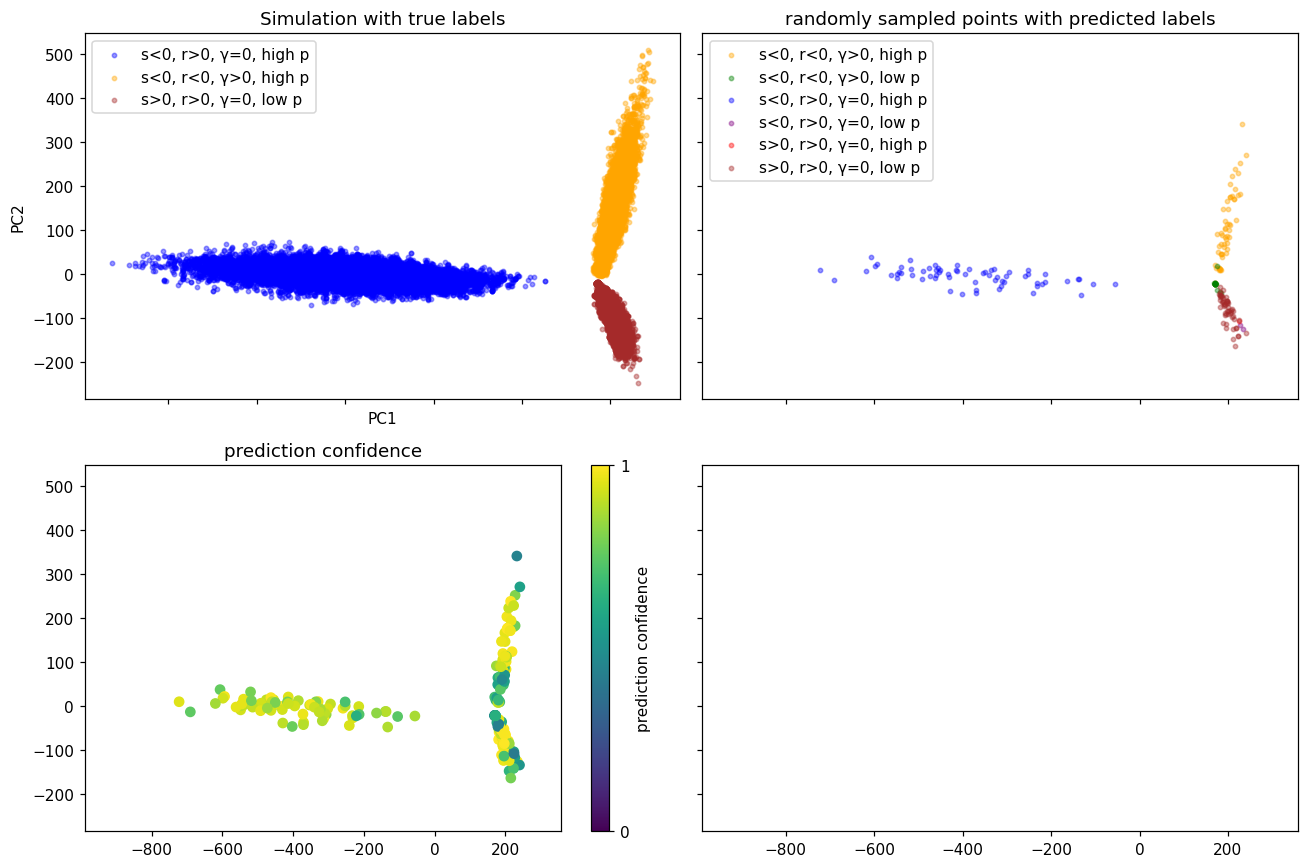

In [13]:
print(n_clusters)
figure, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=110, sharex=True, sharey=True)
axes[0,0].scatter(pca_pop1[:, 0], pca_pop1[:, 1], label=labels[0], color=label_color_map[labels[0]], s=8, alpha=0.4)
axes[0,0].scatter(pca_pop2[:, 0], pca_pop2[:, 1], label=labels[1], color=label_color_map[labels[1]], s=8, alpha=0.4)
axes[0,0].scatter(pca_pop3[:, 0], pca_pop3[:, 1], label=labels[2], color=label_color_map[labels[2]], s=8, alpha=0.4)
# axes[0].scatter(pca_pop4[:, 0], pca_pop4[:, 1], label=labels[3], color=label_color_map[labels[3]], s=8, alpha=0.4)
axes[0,0].set_xlabel("PC1")
axes[0,0].set_ylabel("PC2")
axes[0,0].set_title("Simulation with true labels")
axes[0,0].legend()

heatmap_data = []
for i, label, percentage_vote, n in zip(chosen_indices, pred_labels, confidence_scores, n_clusters):
    heatmap_data.append([pca_result[i][0], pca_result[i][1], pca_result[i][2], label, percentage_vote, n])

for pop_dynamics_label in np.unique([data[3] for data in heatmap_data]):
    PC1s, PC2s, alphas = [], [], []
    for data in heatmap_data:
        if data[3] == pop_dynamics_label:
            PC1s.append(data[0])
            PC2s.append(data[1])
            alphas.append(data[4])
    axes[0,1].scatter(PC1s, PC2s, alpha=0.4, label=f'{pop_dynamics_label}', color=label_color_map[pop_dynamics_label], s=8)
    axes[0,1].set_title("randomly sampled points with predicted labels")
axes[0,1].legend()

PC1s, PC2s, cfs, Ns = [], [], [], []
for data in heatmap_data:
    PC1s.append(data[0])
    PC2s.append(data[1])
    cfs.append(data[4])
    Ns.append(data[5])
# heatmap_data = np.array(heatmap_data)
axes[1,0].set_title("prediction confidence")
im = axes[1,0].scatter(PC1s, PC2s, c=cfs, cmap='viridis')
color_range = [0, 1]
im.set_clim(color_range)
cbar = figure.colorbar(im, ax=axes[1,0])
cbar.ax.set_ylabel('prediction confidence')
cbar.set_ticks(color_range)
plt.tight_layout()

# im = axes[1,1].scatter(PC1s, PC2s, c=cfs, cmap='viridis')
# axes[1,1].set_title("n_clusters")
# im = axes[1,1].scatter(PC1s, PC2s, c=np.log(Ns), cmap='viridis')
# color_range = [np.min(np.log(Ns)), np.max(np.log(Ns))]
# im.set_clim(color_range)
# cbar = figure.colorbar(im, ax=axes[1,1])
# cbar.ax.set_ylabel('log(n_clusters)')
# cbar.set_ticks(color_range)
plt.tight_layout()